<a target="_blank" href="https://colab.research.google.com/github/vnghia/5ma-hddl/blob/main/notebook.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Install dependencies


In [1]:
!pip install -q matplotlib pandas numpy Pillow torch pytorch-lightning albumentations ensemble-boxes tqdm object-detection-metrics rich shapely
!pip install -q git+https://github.com/rwightman/efficientdet-pytorch.git
!pip install -q gdown

# Download dataset


In [2]:
!git clone "https://github.com/vnghia/PeopleArt.git" "people-art" 2>/dev/null

# Import libraries


In [3]:
import matplotlib.pyplot as plt
from matplotlib import patches
from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from PIL import Image
import os

import torch
from torch.utils.data import Dataset, DataLoader

from pytorch_lightning import LightningDataModule, LightningModule, Trainer

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from effdet import create_model
from ensemble_boxes import ensemble_boxes_wbf

from tqdm import tqdm

from podm.metrics import get_pascal_voc_metrics, BoundingBox

from collections import defaultdict

import random

random.seed(0)

import gdown


# Helper class for reading the dataset


In [4]:
class ArtDatasetAdapter:
    def __init__(self, data_dir, keep_train_empty_rate=0, keep_test_empty_rate=1):
        self.keep_train_empty_rate = keep_train_empty_rate
        self.keep_test_empty_rate = keep_test_empty_rate
        self.data_dir = Path(data_dir)
        self.image_dir = self.data_dir / "JPEGImages"
        self.annotation_dir = self.data_dir / "Annotations"
        self.__read_image_list__()
        self.__read_annotation__()

    def __read_image_list__(self):
        self.image_list = defaultdict(list)
        for image_type in ["test", "train", "trainval", "val", "own_test"]:
            with open(self.annotation_dir / f"person_{image_type}.txt", "r") as f:
                merge_image_type = image_type
                if image_type == "trainval":
                    merge_image_type = "train"
                if image_type == "own_test":
                    merge_image_type = "test"
                self.image_list[merge_image_type] += [
                    line.split(" ", maxsplit=1)[0]
                    for line in f.readlines()
                    if (merge_image_type == "val")
                    or (image_type == "own_test")
                    or (
                        merge_image_type == "train"
                        and (
                            int(line.split(" ", maxsplit=1)[1]) == 1
                            or self.keep_train_empty_rate >= random.random()
                        )
                    )
                    or (
                        merge_image_type == "test"
                        and (
                            int(line.split(" ", maxsplit=1)[1]) == 1
                            or self.keep_test_empty_rate >= random.random()
                        )
                    )
                ]

    def __read_annotation__(self):
        annotation_items = []

        for dir in self.annotation_dir.iterdir():
            if not dir.is_dir():
                continue
            for file in dir.iterdir():
                annotation = ET.parse(file)
                filename = os.path.join(
                    annotation.find("folder").text, annotation.find("filename").text
                )
                objects = annotation.findall("object")
                for object in objects:
                    bndbox = object.find("bndbox")
                    annotation_items.append(
                        (
                            filename,
                            int(bndbox[0].text),
                            int(bndbox[1].text),
                            int(bndbox[2].text),
                            int(bndbox[3].text),
                        )
                    )

        self.annotation_df = pd.DataFrame(
            annotation_items,
            columns=["image", "xmin", "ymin", "xmax", "ymax"],
        )

    @classmethod
    def get_rectangle_edges_from_pascal_bbox(cls, bbox):
        xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

        bottom_left = (xmin_top_left, ymax_bottom_right)
        width = xmax_bottom_right - xmin_top_left
        height = ymin_top_left - ymax_bottom_right

        return bottom_left, width, height

    @classmethod
    def draw_pascal_voc_bboxes(cls, plot_ax, class_labels, bboxes):
        for i, bbox in enumerate(bboxes):
            if class_labels[i] < 0:
                continue
            bottom_left, width, height = cls.get_rectangle_edges_from_pascal_bbox(bbox)

            rect_1 = patches.Rectangle(
                bottom_left,
                width,
                height,
                linewidth=4,
                edgecolor="black",
                fill=False,
            )
            rect_2 = patches.Rectangle(
                bottom_left,
                width,
                height,
                linewidth=2,
                edgecolor="white",
                fill=False,
            )

            # Add the patch to the Axes
            plot_ax.add_patch(rect_1)
            plot_ax.add_patch(rect_2)

    @classmethod
    def show_image_bboxes(cls, image, class_labels=None, bboxes=None, figsize=(10, 10)):
        fig, ax = plt.subplots(1, figsize=figsize)
        ax.imshow(image)

        if bboxes is not None:
            cls.draw_pascal_voc_bboxes(ax, class_labels, bboxes)

        plt.show()

    def get_image_and_labels_by_idx(self, index, image_type):
        index = (
            self.image_list[image_type].index(index) if type(index) == str else index
        )
        image_name = self.image_list[image_type][index]
        image = Image.open(self.image_dir / image_name)
        pascal_bboxes = self.annotation_df[self.annotation_df.image == image_name][
            ["xmin", "ymin", "xmax", "ymax"]
        ].values
        class_labels = np.ones(len(pascal_bboxes))
        image_w, image_h = image.size

        if len(pascal_bboxes) == 0:
            pascal_bboxes = np.array([[0, 0, 1, 1]])
            class_labels = np.zeros((1,))

        return image, pascal_bboxes, class_labels, index, image_w, image_h

    def show_image(self, index, image_type="train"):
        image, bboxes, class_labels, image_id, _, _ = self.get_image_and_labels_by_idx(
            index, image_type
        )
        self.show_image_bboxes(image, class_labels, bboxes.tolist())

    def len(self, image_type):
        return len(self.image_list[image_type])

## Initialize adapter


In [5]:
art_ds_adapter = ArtDatasetAdapter("people-art", 0.05, 0.1)

# Pytorch Lightning helper


## Pytorch dataset


In [6]:
class EfficientDetDataset(Dataset):
    def __init__(self, dataset_adaptor, transforms, image_type):
        self.ds = dataset_adaptor
        self.transforms = transforms
        self.image_type = image_type

    def __getitem__(self, index):
        (
            image,
            pascal_bboxes,
            class_labels,
            image_id,
            image_w,
            image_h,
        ) = self.ds.get_image_and_labels_by_idx(index, self.image_type)

        sample = {
            "image": np.array(image, dtype=np.float32),
            "bboxes": pascal_bboxes,
            "labels": class_labels,
        }

        sample = self.transforms(**sample)
        sample["bboxes"] = np.array(sample["bboxes"])
        image = sample["image"]
        pascal_bboxes = sample["bboxes"]
        labels = sample["labels"]

        _, new_h, new_w = image.shape
        sample["bboxes"][:, [0, 1, 2, 3]] = pascal_bboxes[
            :, [1, 0, 3, 2]
        ]  # convert to yxyx

        target = {
            "bboxes": torch.as_tensor(sample["bboxes"], dtype=torch.float32),
            "labels": torch.as_tensor(labels),
            "image_id": torch.tensor([image_id]),
            "image_size": (new_h, new_w),
            "image_scale": torch.tensor([1.0]),
            "image_original_size": (image_h, image_w),
        }

        return image, target, image_id

    def __len__(self):
        return self.ds.len(self.image_type)

## Lightning DataModule


In [7]:
class EfficientDetDataModule(LightningDataModule):
    def __init__(
        self,
        train_dataset_adaptor,
        validation_dataset_adaptor,
        test_dataset_adaptor,
        image_size,
        train_transforms=None,
        valid_transforms=None,
        test_transforms=None,
        num_workers=4,
        batch_size=8,
    ):
        self.image_size = image_size
        self.train_ds = train_dataset_adaptor
        self.valid_ds = validation_dataset_adaptor
        self.test_ds = test_dataset_adaptor
        self.train_transforms = train_transforms or self.get_train_transforms()
        self.valid_transforms = valid_transforms or self.get_valid_transforms()
        self.test_transforms = test_transforms or self.valid_transforms
        self.num_workers = num_workers
        self.batch_size = batch_size
        super().__init__()

        self.train_ds = EfficientDetDataset(
            dataset_adaptor=self.train_ds,
            transforms=self.train_transforms,
            image_type="train",
        )
        self.train_loader = DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

        self.val_ds = EfficientDetDataset(
            dataset_adaptor=self.valid_ds,
            transforms=self.valid_transforms,
            image_type="val",
        )
        self.val_loader = DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

        self.test_ds = EfficientDetDataset(
            dataset_adaptor=self.test_ds,
            transforms=self.test_transforms,
            image_type="test",
        )
        self.test_loader = DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

    def get_train_transforms(self):
        return A.Compose(
            [
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.Transpose(p=0.5),
                A.Resize(height=self.image_size, width=self.image_size, p=1),
                A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ToTensorV2(p=1),
            ],
            p=1.0,
            bbox_params=A.BboxParams(
                format="pascal_voc",
                label_fields=["labels"],
            ),
        )

    def get_valid_transforms(self):
        return A.Compose(
            [
                A.Resize(height=self.image_size, width=self.image_size, p=1),
                A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ToTensorV2(p=1),
            ],
            p=1.0,
            bbox_params=A.BboxParams(
                format="pascal_voc",
                label_fields=["labels"],
            ),
        )

    def train_dataset(self) -> EfficientDetDataset:
        return self.train_ds

    def train_dataloader(self) -> DataLoader:
        return self.train_loader

    def val_dataset(self) -> EfficientDetDataset:
        return self.val_ds

    def val_dataloader(self) -> DataLoader:
        return self.val_loader

    def test_dataset(self) -> EfficientDetDataset:
        return self.test_ds

    def test_dataloader(self, batch_size=None) -> DataLoader:
        return self.test_loader

    def get_item(self, image_type, idx):
        dataset = getattr(self, f"{image_type}_ds")
        (
            original_image,
            pascal_bboxes,
            class_labels,
            _,
            _,
            _,
        ) = dataset.ds.get_image_and_labels_by_idx(idx, dataset.image_type)
        image, target, image_id = dataset[idx]
        image_tensor, annotations, _, _ = self.collate_fn([[image, target, image_id]])
        return (
            original_image,
            pascal_bboxes,
            class_labels,
            image_tensor,
            annotations["image_original_size"],
        )

    @staticmethod
    def collate_fn(batch):
        images, targets, image_ids = tuple(zip(*batch))
        images = torch.stack(images)
        images = images.float()

        boxes = [target["bboxes"].float() for target in targets]
        labels = [target["labels"].float() for target in targets]
        image_size = torch.tensor([target["image_size"] for target in targets]).float()
        image_scale = torch.tensor(
            [target["image_scale"] for target in targets]
        ).float()
        image_original_size = torch.tensor(
            [target["image_original_size"] for target in targets]
        ).float()

        annotations = {
            "bbox": boxes,
            "cls": labels,
            "img_size": image_size,
            "img_scale": image_scale,
            "image_original_size": image_original_size,
        }

        return images, annotations, targets, image_ids

## Lightning Module


In [8]:
class EfficientDetModelWrapper(LightningModule):
    def __init__(
        self,
        dm,
        num_classes=1,
        prediction_confidence_threshold=0.2,
        learning_rate=0.0002,
        wbf_iou_threshold=0.44,
        model_name="efficientdetv2_ds",
        title=None,
        model=None,
    ):
        super().__init__()
        self.dm = dm
        self.image_size = self.dm.image_size
        self.model_name = model_name
        self.title = title or self.model_name
        self.num_classes = num_classes
        self.model = model or create_model(
            self.model_name,
            "train",
            self.num_classes,
            bench_labeler=True,
            pretrained_backbone=True,
        )
        self.prediction_confidence_threshold = prediction_confidence_threshold
        self.lr = learning_rate
        self.wbf_iou_threshold = wbf_iou_threshold

    def forward(self, images, targets):
        return self.model(images, targets)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        images, annotations, _, image_ids = batch

        losses = self.model(images, annotations)

        logging_losses = {
            "class_loss": losses["class_loss"].detach(),
            "box_loss": losses["box_loss"].detach(),
        }

        self.log(
            "train_loss",
            losses["loss"],
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        self.log(
            "train_class_loss",
            losses["class_loss"],
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        self.log(
            "train_box_loss",
            losses["box_loss"],
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        return losses["loss"]

    @torch.no_grad()
    def validation_step(self, batch, batch_idx, log=True):
        images, annotations, targets, image_ids = batch
        outputs = self.model(images, annotations)

        detections = outputs["detections"]

        batch_predictions = {
            "predictions": detections,
            "targets": targets,
            "image_ids": image_ids,
        }

        if log:
            logging_losses = {
                "class_loss": outputs["class_loss"].detach(),
                "box_loss": outputs["box_loss"].detach(),
            }

            self.log(
                "valid_loss",
                outputs["loss"],
                on_step=True,
                on_epoch=True,
                prog_bar=True,
                logger=True,
                sync_dist=True,
            )
            self.log(
                "valid_class_loss",
                logging_losses["class_loss"],
                on_step=True,
                on_epoch=True,
                prog_bar=True,
                logger=True,
                sync_dist=True,
            )
            self.log(
                "valid_box_loss",
                logging_losses["box_loss"],
                on_step=True,
                on_epoch=True,
                prog_bar=True,
                logger=True,
                sync_dist=True,
            )

        return {"loss": outputs["loss"], "batch_predictions": batch_predictions}

    def predict(self, images_tensor, image_sizes=None):
        if images_tensor.ndim == 3:
            images_tensor = images_tensor.unsqueeze(0)
        if (
            images_tensor.shape[-1] != self.image_size
            or images_tensor.shape[-2] != self.image_size
        ):
            raise ValueError(
                f"Input tensors must be of shape (N, 3, {self.image_size}, {self.image_size})"
            )

        return self.__run_inference(images_tensor, image_sizes)

    def __run_inference(self, images_tensor, image_sizes=None):
        num_images = images_tensor.shape[0]

        dummy_targets = self._create_dummy_inference_targets(num_images=num_images)

        detections = self.model(images_tensor, dummy_targets)["detections"]
        (
            predicted_bboxes,
            predicted_class_confidences,
            predicted_class_labels,
        ) = self.post_process_detections(detections)

        scaled_bboxes = self.rescale_bboxes(
            predicted_bboxes=predicted_bboxes, image_sizes=image_sizes
        )

        return scaled_bboxes, predicted_class_labels, predicted_class_confidences

    def _create_dummy_inference_targets(self, num_images):
        dummy_targets = {
            "bbox": [
                torch.tensor([[0.0, 0.0, 0.0, 0.0]], device=self.device)
                for i in range(num_images)
            ],
            "cls": [torch.tensor([1.0], device=self.device) for i in range(num_images)],
            "img_size": torch.tensor(
                [(self.image_size, self.image_size)] * num_images, device=self.device
            ).float(),
            "img_scale": torch.ones(num_images, device=self.device).float(),
        }

        return dummy_targets

    def post_process_detections(self, detections):
        predictions = []
        for i in range(detections.shape[0]):
            predictions.append(
                self._postprocess_single_prediction_detections(detections[i])
            )

        (
            predicted_bboxes,
            predicted_class_confidences,
            predicted_class_labels,
        ) = self.__run_wbf(predictions, iou_thr=self.wbf_iou_threshold)

        return predicted_bboxes, predicted_class_confidences, predicted_class_labels

    def _postprocess_single_prediction_detections(self, detections):
        boxes = detections.detach().cpu().numpy()[:, :4]
        scores = detections.detach().cpu().numpy()[:, 4]
        classes = detections.detach().cpu().numpy()[:, 5]
        indexes = np.where(
            (scores > self.prediction_confidence_threshold) & (classes == 1)
        )[0]

        return {
            "boxes": boxes[indexes],
            "scores": scores[indexes],
            "classes": classes[indexes],
        }

    def rescale_bboxes(self, predicted_bboxes, image_sizes=None):
        if image_sizes is None:
            return predicted_bboxes
        scaled_bboxes = []
        for bboxes, image_dims in zip(predicted_bboxes, image_sizes):
            im_h, im_w = image_dims

            if len(bboxes) > 0:
                scaled_bboxes.append(
                    (
                        np.array(bboxes)
                        * [
                            im_w / self.image_size,
                            im_h / self.image_size,
                            im_w / self.image_size,
                            im_h / self.image_size,
                        ]
                    ).tolist()
                )
            else:
                scaled_bboxes.append(bboxes)

        return scaled_bboxes

    def __run_wbf(self, predictions, iou_thr=0.44, skip_box_thr=0.43, weights=None):
        bboxes = []
        confidences = []
        class_labels = []

        for prediction in predictions:
            boxes = [(prediction["boxes"] / self.image_size).tolist()]
            scores = [prediction["scores"].tolist()]
            labels = [prediction["classes"].tolist()]

            boxes, scores, labels = ensemble_boxes_wbf.weighted_boxes_fusion(
                boxes,
                scores,
                labels,
                weights=weights,
                iou_thr=iou_thr,
                skip_box_thr=skip_box_thr,
            )
            boxes = boxes * (self.image_size - 1)
            bboxes.append(boxes.tolist())
            confidences.append(scores.tolist())
            class_labels.append(labels.tolist())

        return bboxes, confidences, class_labels

    def eval_model(self, loader):
        predicted_bboxes = []
        ground_truth_bboxes = []
        for batch in tqdm(loader):
            image_tensor, annotations, targets, image_ids = batch
            (
                scaled_bboxes,
                predicted_class_labels,
                predicted_class_confidences,
            ) = self.predict(image_tensor)
            for i, target in enumerate(targets):
                bboxes, labels, image_id, _, _, _ = target.values()
                for bbox, label in zip(bboxes[..., [1, 0, 3, 2]], labels):
                    ground_truth_bboxes.append(
                        BoundingBox.of_bbox(
                            int(image_id[0]),
                            int(label),
                            bbox[0],
                            bbox[1],
                            bbox[2],
                            bbox[3],
                        )
                    )
                bboxes, labels, confidences = (
                    scaled_bboxes[i],
                    predicted_class_labels[i],
                    predicted_class_confidences[i],
                )
                for bbox, label, confidence in zip(bboxes, labels, confidences):
                    predicted_bboxes.append(
                        BoundingBox.of_bbox(
                            int(image_id[0]),
                            int(label),
                            bbox[0],
                            bbox[1],
                            bbox[2],
                            bbox[3],
                            confidence,
                        )
                    )
        aps = []
        for i in range(10):
            iou_threshold = 0.5 + i * 0.05
            aps.append(
                get_pascal_voc_metrics(
                    ground_truth_bboxes, predicted_bboxes, iou_threshold
                )[1].ap
            )
        return {"AP.5": aps[0], "AP.75": aps[5], "AP.5:.95:.05": sum(aps) / len(aps)}

    @classmethod
    def get_pretrained_wrapper(cls, model_name, image_size, art_ds_adapter, **kwargs):
        pretrained_model = create_model(
            model_name,
            "train",
            pretrained=True,
            bench_labeler=True,
        )
        pretrained_model_wrapper = cls(
            dm=EfficientDetDataModule(
                train_dataset_adaptor=art_ds_adapter,
                validation_dataset_adaptor=art_ds_adapter,
                test_dataset_adaptor=art_ds_adapter,
                image_size=image_size,
                num_workers=1,
                batch_size=4,
            ),
            num_classes=1,
            model=pretrained_model,
            **kwargs,
        )
        return pretrained_model_wrapper.eval()

    @staticmethod
    def compare_bboxes_for_image(
        image_type, image_index, figsize=(20, 20), *args, ncols=2
    ):
        wrapper_count = len(args)
        nrows = int((wrapper_count + 1) / ncols + 0.5)
        _, axes = plt.subplots(
            nrows, ncols, figsize=figsize, squeeze=False, sharex=True, sharey=True
        )
        for i, wrapper in enumerate(args):
            (
                original_image,
                pascal_bboxes,
                class_labels,
                image_tensor,
                image_sizes,
            ) = wrapper.dm.get_item(image_type, image_index)
            if i == 0:
                gt_ax = axes[0, 0]
                gt_ax.imshow(original_image)
                gt_ax.set_title("Ground Truth")
                gt_ax.set_xticks([])
                gt_ax.set_yticks([])
                art_ds_adapter.draw_pascal_voc_bboxes(
                    gt_ax, class_labels, pascal_bboxes
                )
            (
                predicted_bboxes,
                predicted_class_labels,
                predicted_class_confidences,
            ) = wrapper.predict(image_tensor, image_sizes)
            ax = axes[int((i + 1) / ncols), (i + 1) % ncols]
            ax.imshow(original_image)
            ax.set_title(wrapper.title)
            ax.set_xticks([])
            ax.set_yticks([])
            art_ds_adapter.draw_pascal_voc_bboxes(
                ax, predicted_class_labels[0], predicted_bboxes[0]
            )

        plt.show()


# Training and testing


## Initialize model wrapper


In [9]:
model_wrapper = EfficientDetModelWrapper(
    dm=EfficientDetDataModule(
        train_dataset_adaptor=art_ds_adapter,
        validation_dataset_adaptor=art_ds_adapter,
        test_dataset_adaptor=art_ds_adapter,
        image_size=768,
        num_workers=1,
        batch_size=4,
    ),
    num_classes=1,
    model_name="efficientdetv2_dt",
    title="Our EfficientDetv2",
)


In [10]:
ckpt_path = Path(f"epoch=99-step=20800-model={model_wrapper.model_name}.ckpt")

# If gdown can not download this link, please download at
# https://drive.google.com/file/d/1DMFRT3pomIOUICtSuqzRdqZib-3wQamA/view
if not ckpt_path.exists() and bool(os.environ.get("USE_PRETRAINED_MODEL", "1")):
    gdown.download(
        "https://drive.google.com/uc?export=download&confirm=pbef&id=1DMFRT3pomIOUICtSuqzRdqZib-3wQamA",
        output=str(ckpt_path),
        quiet=False,
    )

if not ckpt_path.exists():
    trainer = Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=100,
        num_sanity_val_steps=0,
    )
    trainer.fit(model_wrapper, datamodule=model_wrapper.dm)
    trainer.save_checkpoint(ckpt_path)
else:
    model_wrapper = EfficientDetModelWrapper.load_from_checkpoint(
        ckpt_path,
        dm=model_wrapper.dm,
        num_classes=model_wrapper.num_classes,
        model_name=model_wrapper.model_name,
        title=model_wrapper.title,
    )
_ = model_wrapper.eval()


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1DMFRT3pomIOUICtSuqzRdqZib-3wQamA
To: /home/xana/code/efficientdet/epoch=99-step=20800-model=efficientdetv2_dt.ckpt
100%|██████████| 163M/163M [00:28<00:00, 5.82MB/s] 


## Initialize pretrained EfficientDet backbone EfficientNetv2


In [11]:
effdet_v2_dt_wrapper = EfficientDetModelWrapper.get_pretrained_wrapper(
    model_wrapper.model_name,
    model_wrapper.image_size,
    art_ds_adapter,
    title="EfficientDetv2",
)

## Initialize pretrained EfficientDet backbone EfficientNetv1 D4


In [12]:
effdet_v1_d4_wrapper = EfficientDetModelWrapper.get_pretrained_wrapper(
    "tf_efficientdet_d4", 1024, art_ds_adapter, title="EfficientDetv1 D4"
)

Downloading: "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d4_49-f56376d9.pth" to /home/xana/.cache/torch/hub/checkpoints/tf_efficientdet_d4_49-f56376d9.pth


## Show an example output


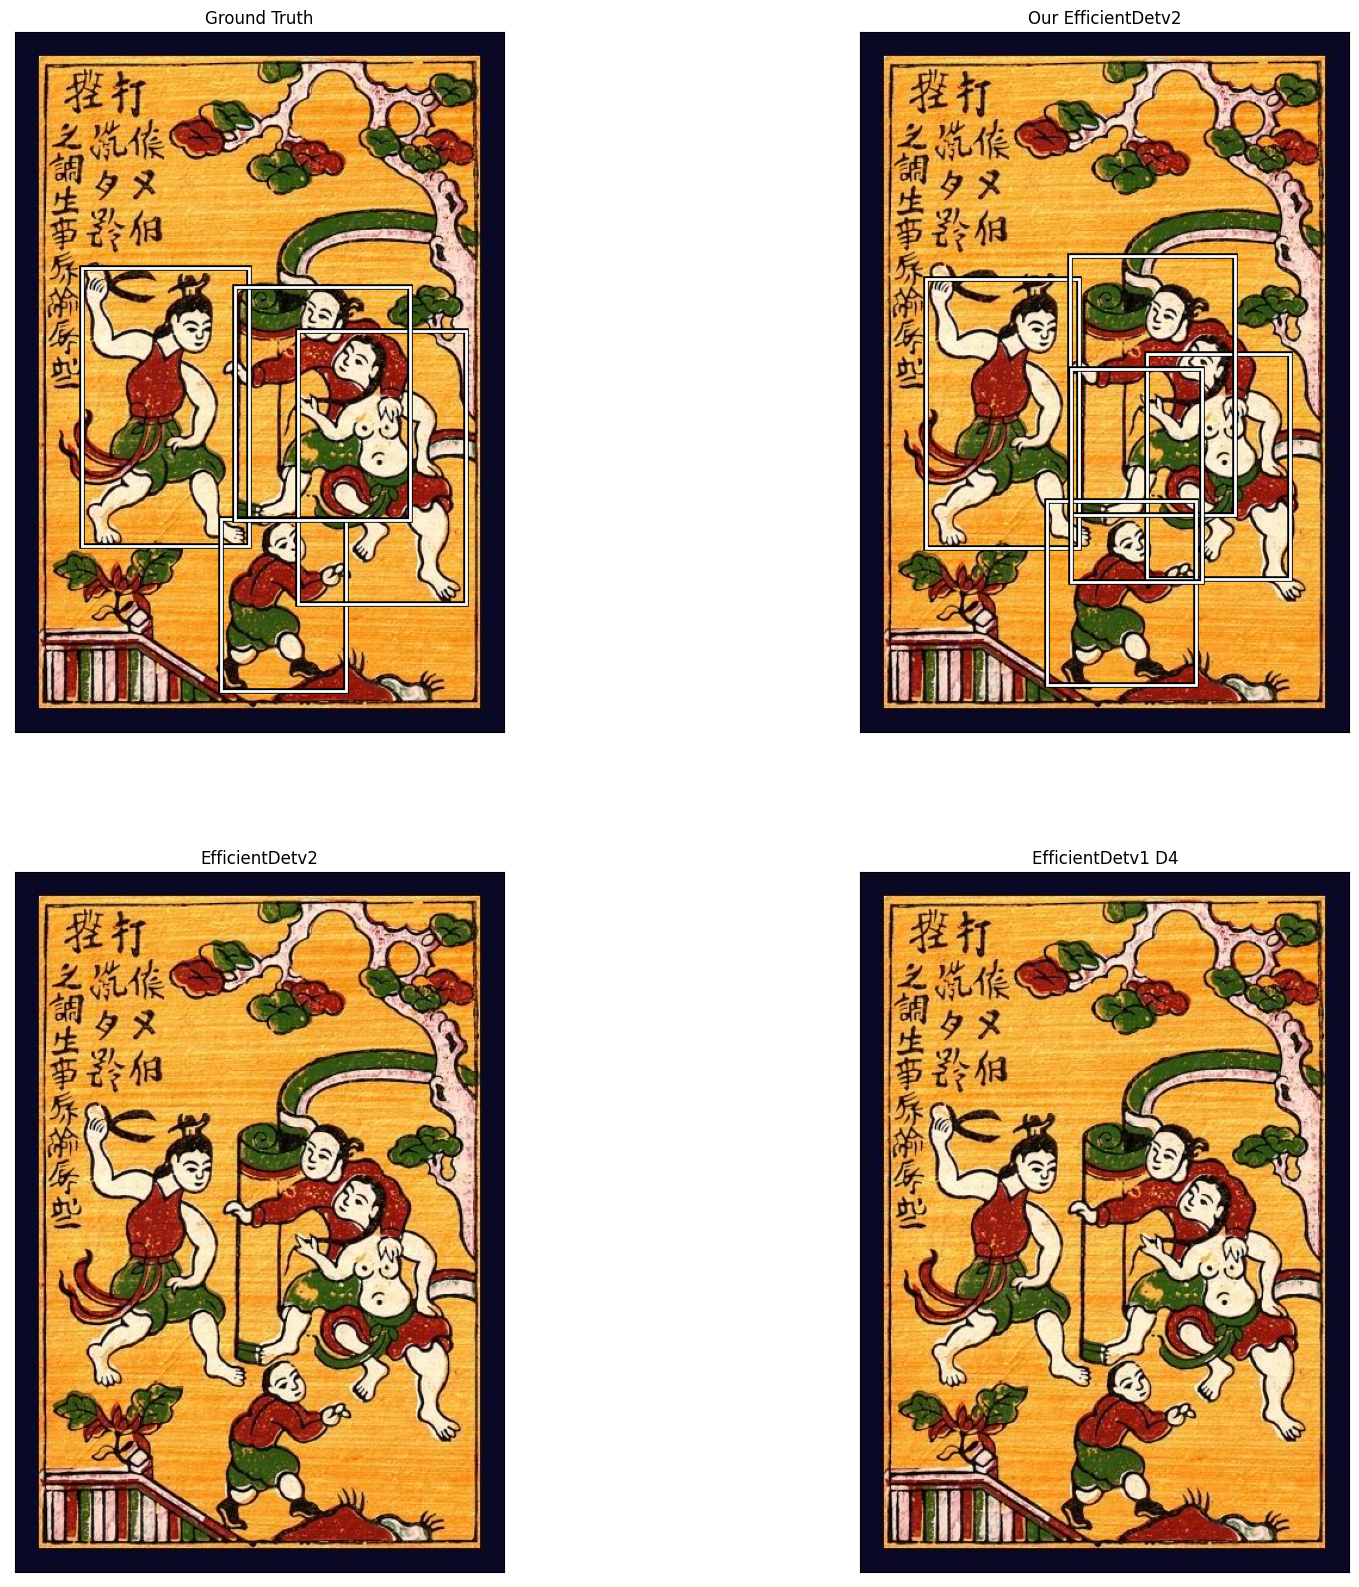

In [13]:
example_index = "DongHo/danh-ghen.jpg"
EfficientDetModelWrapper.compare_bboxes_for_image(
    "test",
    example_index,
    (20, 20),
    model_wrapper,
    effdet_v2_dt_wrapper,
    effdet_v1_d4_wrapper,
    ncols=2,
)
